In [12]:
import sys
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import RDConfig
import seaborn as sns
sys.path.append(os.path.join(RDConfig.RDContribDir,'SA_Score'))
import sascorer
from tqdm.auto import tqdm
import useful_rdkit_utils as uru

In [13]:
tqdm.pandas()

Read the data

In [14]:
df = pd.read_csv("chemical_intution_eval.csv")
df.dataset.value_counts()

ChEMBL    2000
REOS      2000
Drug      2000
Odd       2000
Name: dataset, dtype: int64

Add molecules and descriptors

In [15]:
reos = uru.REOS()
reos.set_active_rule_sets(['BMS'])

In [16]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)
df['qed'] = df.mol.progress_apply(qed)
df['sa_score'] = df.mol.progress_apply(sascorer.calculateScore)
df[['rule_set','reos']] = df.mol.progress_apply(reos.process_mol).tolist()

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [17]:
df['reos_ok'] = df.reos == "ok"

<Axes: xlabel='Dataset', ylabel='Fraction OK'>

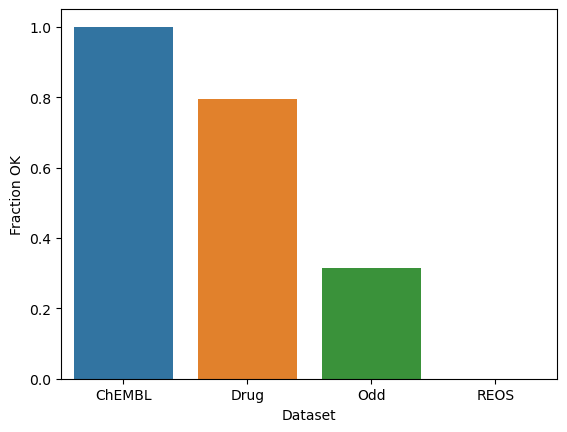

In [20]:
res = []
for k,v in df.groupby("dataset"):
    res.append([k,len(v.query("reos == 'ok'"))/len(v)])
res_df = pd.DataFrame(res,columns=["Dataset","Fraction OK"])
sns.barplot(x="Dataset",y="Fraction OK",data=res_df)

In [21]:
df.query("dataset == 'Odd'").reos.value_counts()

ok                         628
aldehyde                   170
boron_warhead              135
bad_cations                134
bad_boron                  124
                          ... 
thioester                    1
quat_N_acyl                  1
thiocarbonate                1
tertiary_halide_sulfate      1
aryl_phosphonate             1
Name: reos, Length: 71, dtype: int64

QED seems to do a reasonably good job of recognizing the REOS and Odd molecules

Text(0.5, 0, 'QED')

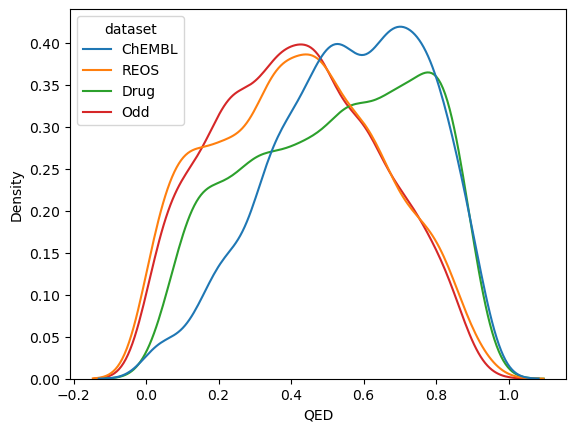

In [22]:
ax = sns.kdeplot(x="qed",hue="dataset",data=df)
ax.set_xlabel("QED")

SA Score does a good job of picking out weird molecules that probabaly can't exist

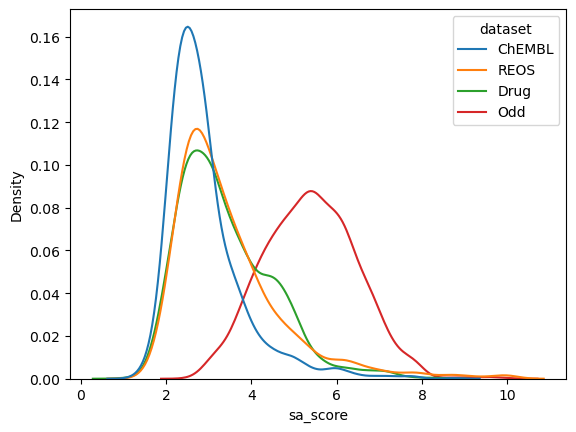

In [23]:
ax = sns.kdeplot(x="sa_score",hue="dataset",data=df)
ax.set_label("SA Score")